In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization
import visualkeras

In [3]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] +self.w3 * inputs[2]

In [4]:
labels_csv = pd.read_csv('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\\Codes\\Dog-Breed-Classification-using-Ensemble-Pretrained-Models-main\\labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]
data_train = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')
data_test = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')

data_train1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')
data_test1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')

In [5]:
batch_size = 16
img_size = 224

In [6]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="validation",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [7]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
inceptionV3 = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(299,299,3))

for layer in vgg16 .layers:
    layer.trainable=False
for layer in resnet50.layers:
    layer.trainable=False
for layer in inceptionV3.layers:
    layer.trainable=False

model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

model1.add(vgg16)
model1.add(BatchNormalization())
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(120, activation='softmax'))

model2.add(resnet50)
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(120, activation='softmax'))

model3.add(inceptionV3)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(120, activation='softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
# model1.save('model1.h5')
# model2.save('model2.h5')
# model3.save('model3.h5')

# history_vgg = model1.fit(train_generator, epochs=20, verbose = 1,
#                          validation_data=validation_generator)
#
# history_res = model2.fit(train_generator, epochs=20, verbose = 1,
#                        validation_data=validation_generator)
#
# history_inc = model3.fit(train_generator, epochs=20, verbose = 1,
#                         validation_data=validation_generator)


In [8]:
models = [model1,model2]
models1 = [model3]

model_input = tf.keras.Input(shape=(224, 224, 3))
model_input1 = tf.keras.Input(shape=(299, 299, 3))

model_outputs = [model(model_input) for model in models]

ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_outputs = [model(model_input1) for model in models1]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input1, outputs=ensemble_output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])


ensemble_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 120)               24032152  
                                                                 
 average_1 (Average)         (None, 120)               0         
                                                                 
Total params: 24,032,152
Trainable params: 2,225,272
Non-trainable params: 21,806,880
_________________________________________________________________


In [9]:
history_ens = ensemble_model.fit(train_generator, epochs=20, verbose = 1,
                                 validation_data=validation_generator)

Epoch 1/20
512/512 [==============================] - 224s 429ms/step - loss: 5.1217 - accuracy: 0.0124 - val_loss: 4.7536 - val_accuracy: 0.0220
Epoch 2/20
512/512 [==============================] - 218s 427ms/step - loss: 4.8951 - accuracy: 0.0214 - val_loss: 4.6935 - val_accuracy: 0.0250
Epoch 3/20
512/512 [==============================] - 218s 426ms/step - loss: 4.7744 - accuracy: 0.0296 - val_loss: 4.6778 - val_accuracy: 0.0240
Epoch 4/20
512/512 [==============================] - 214s 418ms/step - loss: 4.6594 - accuracy: 0.0358 - val_loss: 4.6527 - val_accuracy: 0.0274
Epoch 5/20
512/512 [==============================] - 215s 419ms/step - loss: 4.5707 - accuracy: 0.0448 - val_loss: 4.6438 - val_accuracy: 0.0318
Epoch 6/20
512/512 [==============================] - 216s 422ms/step - loss: 4.4873 - accuracy: 0.0581 - val_loss: 4.6293 - val_accuracy: 0.0298
Epoch 7/20
512/512 [==============================] - 217s 424ms/step - loss: 4.4056 - accuracy: 0.0622 - val_loss: 4.6282 -

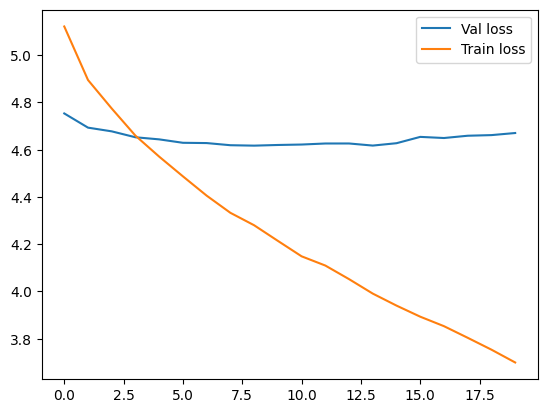

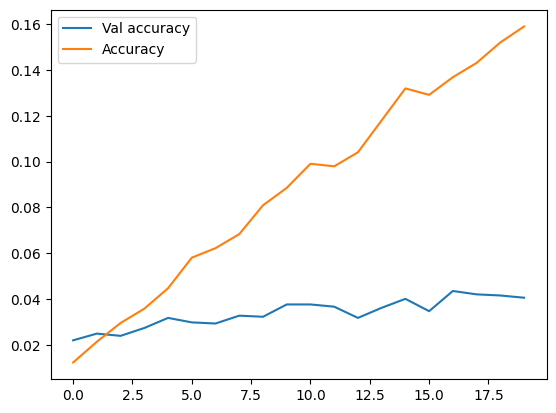

In [10]:
plt.figure()
plt.plot(history_ens .history["val_loss"], label = "Val loss")
plt.plot(history_ens .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ens .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ens .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

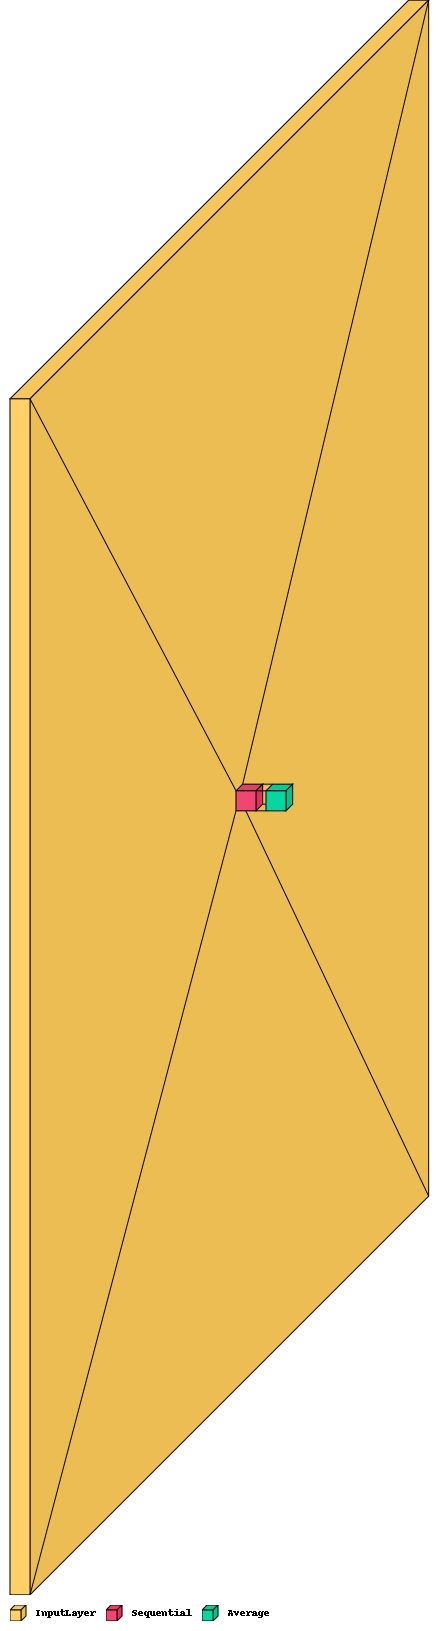

In [11]:
visualkeras.layered_view(ensemble_model,  legend=True)

NameError: name 'labels_csv' is not defined